# Personal Information
Name: **Jill Gulbis**

StudentID: **14584816**

Email: [**jill.gulbis@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **22.03.2024**

# Data Context

The context of this research involves determining PM2.5 levels (a type of pollution) from Tata Steel, a steel company in the north of the Netherlands, through an image-based ML model. The site is being monitored from 3 camera angles and this public footage is live streamed on Youtube. Furthermore, public sensors record the PM2.5 levels surrounding the terrain on an hourly basis. Along with hourly weather data, the model can be trained in a supervised fashion by performing image-based regression analysis on the emitted Pm2.5 levels.
In sum, there are 3 datasets I will be working with: 
1. Weather Data retrieved from https://daggegevens.knmi.nl/klimatologie/uurgegevens :
Involves features such as temperature, precipitation levels, wind direction and speed.
2. Sensor Data retrieved from https://samenmeten.rivm.nl/dataportaal/ : Includes pm2.5 levels, geolocation sof the sensors, date and time
3. Camera footage retrieved from https://www.youtube.com/watch?v=5cKPaRo-Ehs&ab_channel=FrisseWindNu : The footage is not available yet however, my supervisor is working on scraping the data together with the engineers.

Finally, it is important to note that high instances of PM2.5 levels are rare, which means there is a strong right tail skewness in the sensor data. This will be accounted for but is important to visualise in this EDA.


# Data Description

![image](EDA_summary.drawio.png)


In [483]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import math

### Data Loading

In [484]:
# Loading data
weather_df = pd.read_csv(r'../Data/Weather data/result 9.txt', delimiter= '\t|,', header = 32)
sensor_df = pd.read_csv(r'../Data/Sensor Data/data_Velsen_2023-06-15_2024-02-15.csv')

/var/folders/hc/j20f244d2v56_dq4x9gmc3gm0000gn/T/ipykernel_75161/666913672.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  weather_df = pd.read_csv(r'../Data/Weather data/result 9.txt', delimiter= '\t|,', header = 32)


### Analysis 1:  Weather Data
- Preprocessing the weather data involves combining two separate weather sensor tables into one. There are several weather stations in the Netherlands and stations in close vicinity to each other do not record the same variables as weather data is more or less uniform, regionally. 
- General statistics such as the size of the dataset, number of missing values and min, max, or average of features are presented
- Furthermore, values are converted into one unit per second instead of 0.1 units per second for interpretability. Think of temperature where 301 degrees is in fact 30.1 degrees. Other common techniques such as removal of missing values are also performed. 
- Time dependent variables are plotted to verify how temperature, sun duration etc. is distributed over time. This is to verify seasonal dependency and the reliability of the public data.
- Feature engineering: I also feature engineer date and time columns such that the table can easily be merged with sensor data and linked to time stamps of the recorded camera footage. 

##### Weather Data: Preprocessing

In [485]:
# Preprocess the weather column names (get rid of white space)
weather_df.columns = [i.strip() for i in weather_df.columns]
weather_df.columns

# 257 and 225 are two different weather stations next to each other.
# They measure different variables which is why I will be joining the columns to get one table with all the weather values
station_257 = weather_df[weather_df['# STN'] == 257]
station_225 = weather_df[weather_df['# STN'] == 225]

# Keep relevant columns from station 225
# STN = Station Number
# YYYYMMDD = date
# HH = Hour of day
# DD = Mean wind direction (in degrees) during the 10-minute period preceding the time of observation (360=north; 90=east; 180=south; 270=west; 0=calm 990=variable)
# FH = Hourly mean wind speed (in 0.1 m/s)
# FX = Mean wind speed (in 0.1 m/s) during the 10-minute period preceding the time of observation
# FF = Maximum wind gust (in 0.1 m/s) during the hourly division
station_225 = station_225[["# STN", "YYYYMMDD", "HH", "DD", "FH", "FX", "FF"]]

# Keep relevant columns from station 257 
# STN = Station Number
# YYYYMMDD = date
# T    = Temperature (in 0.1 degrees Celsius) at 1.50 m at the time of observation
# TD   = Dew point temperature (in 0.1 degrees Celsius) at 1.50 m at the time of observation
# SQ   = Sunshine duration (in 0.1 hour) during the hourly division; calculated from global radiation (-1 for <0.05 hour)
# Q    = Global radiation (in J/cm2) during the hourly division
# DR   = Precipitation duration (in 0.1 hour) during the hourly division
# RH   = Hourly precipitation amount (in 0.1 mm) (-1 for <0.05 mm)
# U    = Relative atmospheric humidity (in percents) at 1.50 m at the time of observation
station_257 = station_257[["# STN", "YYYYMMDD", "HH", "T", "TD", "SQ", "Q", "DR", "RH", "U"]]

# Join both dataframes on date and time
weather_station_df = pd.merge(station_225, station_257, on=["YYYYMMDD", "HH"], suffixes=('_225', '_257'))

# Dataset statistics
print("---------------------------------------------------")
print("STATISTICS")
print("Minimum date:", weather_station_df["YYYYMMDD"].min())
print("Maximum date:", weather_station_df["YYYYMMDD"].max())
print("Number of instances:", len(weather_station_df))
print("Number of missing values:", weather_station_df.isna().sum().sum())

# Convert columns to numeric
weather_features = ["DD", "FH", "FX", "FF", "T", "TD", "SQ", "Q", "DR", "RH", "U"]

# Create name dictionary to decipher abbreviations
name_dict = {"DD": "mean_wind_direction", "FH": "hourly_mean_wind_speed", "FX": "mean_wind_speed", 'FF': "max_wind_gust", "T": "temperature", 
             "TD": "dew_point_temperature","SQ": "sunshine_duration", "Q": "global_radiation", "DR": "precipitation_duration", 
             "RH": "hourly_precipitation_amount", "U": "relative_atmospheric_humidity"}

# Concver to numeric
for i in weather_features:
    weather_station_df[i] = pd.to_numeric(weather_station_df[i])

# Convert values to 0.1 values. For this I copy the list to be
# converted and remove DD, U and Q because they don't need to be multiplied by 0.1
w_conversion_df = weather_features.copy()
w_conversion_df.remove("DD")
w_conversion_df.remove("U")
w_conversion_df.remove("Q")

for i in w_conversion_df:
    weather_station_df[i] = weather_station_df[i]*0.1

# Calculate statistics
stat_columns = ["variable", "full_name", "min", "max", "average"]
weather_stats = pd.DataFrame(index = range(0,len(weather_features)-1), columns=stat_columns)
name_dict_list = list(name_dict.items())

for i in range(len(weather_features)-1):
    variable = weather_features[i]
    weather_stats.loc[i]["variable"] = variable

    name = name_dict_list[i][1]
    weather_stats.loc[i]["full_name"] = name

    min_val = weather_station_df[variable].min()
    weather_stats.loc[i]["min"] = min_val

    max_val = weather_station_df[variable].max()
    weather_stats.loc[i]["max"] = max_val

    average_val = weather_station_df[variable].mean()
    weather_stats.loc[i]["average"] = round(average_val, 2)

weather_stats

---------------------------------------------------
STATISTICS
Minimum date: 20230615
Maximum date: 20231215
Number of instances: 4416
Number of missing values: 0


,variable,full_name,min,max,average
0,DD,mean_wind_direction,0,990,200.77
1,FH,hourly_mean_wind_speed,0.0,30.0,7.42
2,FX,mean_wind_speed,1.0,41.0,10.21
3,FF,max_wind_gust,0.0,31.0,7.44
4,T,temperature,-5.3,31.5,14.76
5,TD,dew_point_temperature,-6.1,20.4,11.19
6,SQ,sunshine_duration,0.0,1.0,0.22
7,Q,global_radiation,0,327,47.96
8,DR,precipitation_duration,0.0,1.0,0.1
9,RH,hourly_precipitation_amount,-0.1,12.6,0.16


##### Weather data: Add date and time columns

In [486]:
# Convert 'datetime' column to datetime type
weather_station_df['datetime'] = pd.to_datetime(weather_station_df['YYYYMMDD'], format = '%Y%m%d')

# Split 'datetime' column into 'date' and 'time' columns
weather_station_df['date'] = weather_station_df['datetime'].dt.date
weather_station_df['time'] = pd.to_datetime(weather_station_df['HH'], format= "%H", errors="coerce").dt.time

In [487]:
weather_station_df.head(10)

,# STN_225,YYYYMMDD,HH,DD,FH,FX,FF,# STN_257,T,TD,SQ,Q,DR,RH,U,datetime,date,time
0,225,20230615,1,70,6.0,8.0,6.0,257,15.0,12.8,0.0,0,0.0,0.0,86,2023-06-15,2023-06-15,01:00:00
1,225,20230615,2,80,5.0,7.0,5.0,257,14.2,12.4,0.0,0,0.0,0.0,89,2023-06-15,2023-06-15,02:00:00
2,225,20230615,3,80,5.0,6.0,5.0,257,14.3,12.2,0.0,0,0.0,0.0,87,2023-06-15,2023-06-15,03:00:00
3,225,20230615,4,80,5.0,5.0,4.0,257,14.5,12.1,0.0,3,0.0,0.0,85,2023-06-15,2023-06-15,04:00:00
4,225,20230615,5,80,5.0,5.0,5.0,257,16.3,12.6,1.0,30,0.0,0.0,78,2023-06-15,2023-06-15,05:00:00
5,225,20230615,6,70,4.0,5.0,3.0,257,18.9,13.7,1.0,78,0.0,0.0,71,2023-06-15,2023-06-15,06:00:00
6,225,20230615,7,80,3.0,3.0,3.0,257,20.6,14.0,1.0,133,0.0,0.0,66,2023-06-15,2023-06-15,07:00:00
7,225,20230615,8,80,3.0,4.0,3.0,257,21.6,13.5,1.0,187,0.0,0.0,60,2023-06-15,2023-06-15,08:00:00
8,225,20230615,9,70,4.0,6.0,4.0,257,22.8,13.6,1.0,236,0.0,0.0,56,2023-06-15,2023-06-15,09:00:00
9,225,20230615,10,70,5.0,7.0,4.0,257,24.4,9.5,1.0,277,0.0,0.0,38,2023-06-15,2023-06-15,10:00:00


##### Weather Data: Subplots of variables over time

This allows to analyse the general trends over time such as temperature and radiation decreasing, and precipitation duration increasing during winter

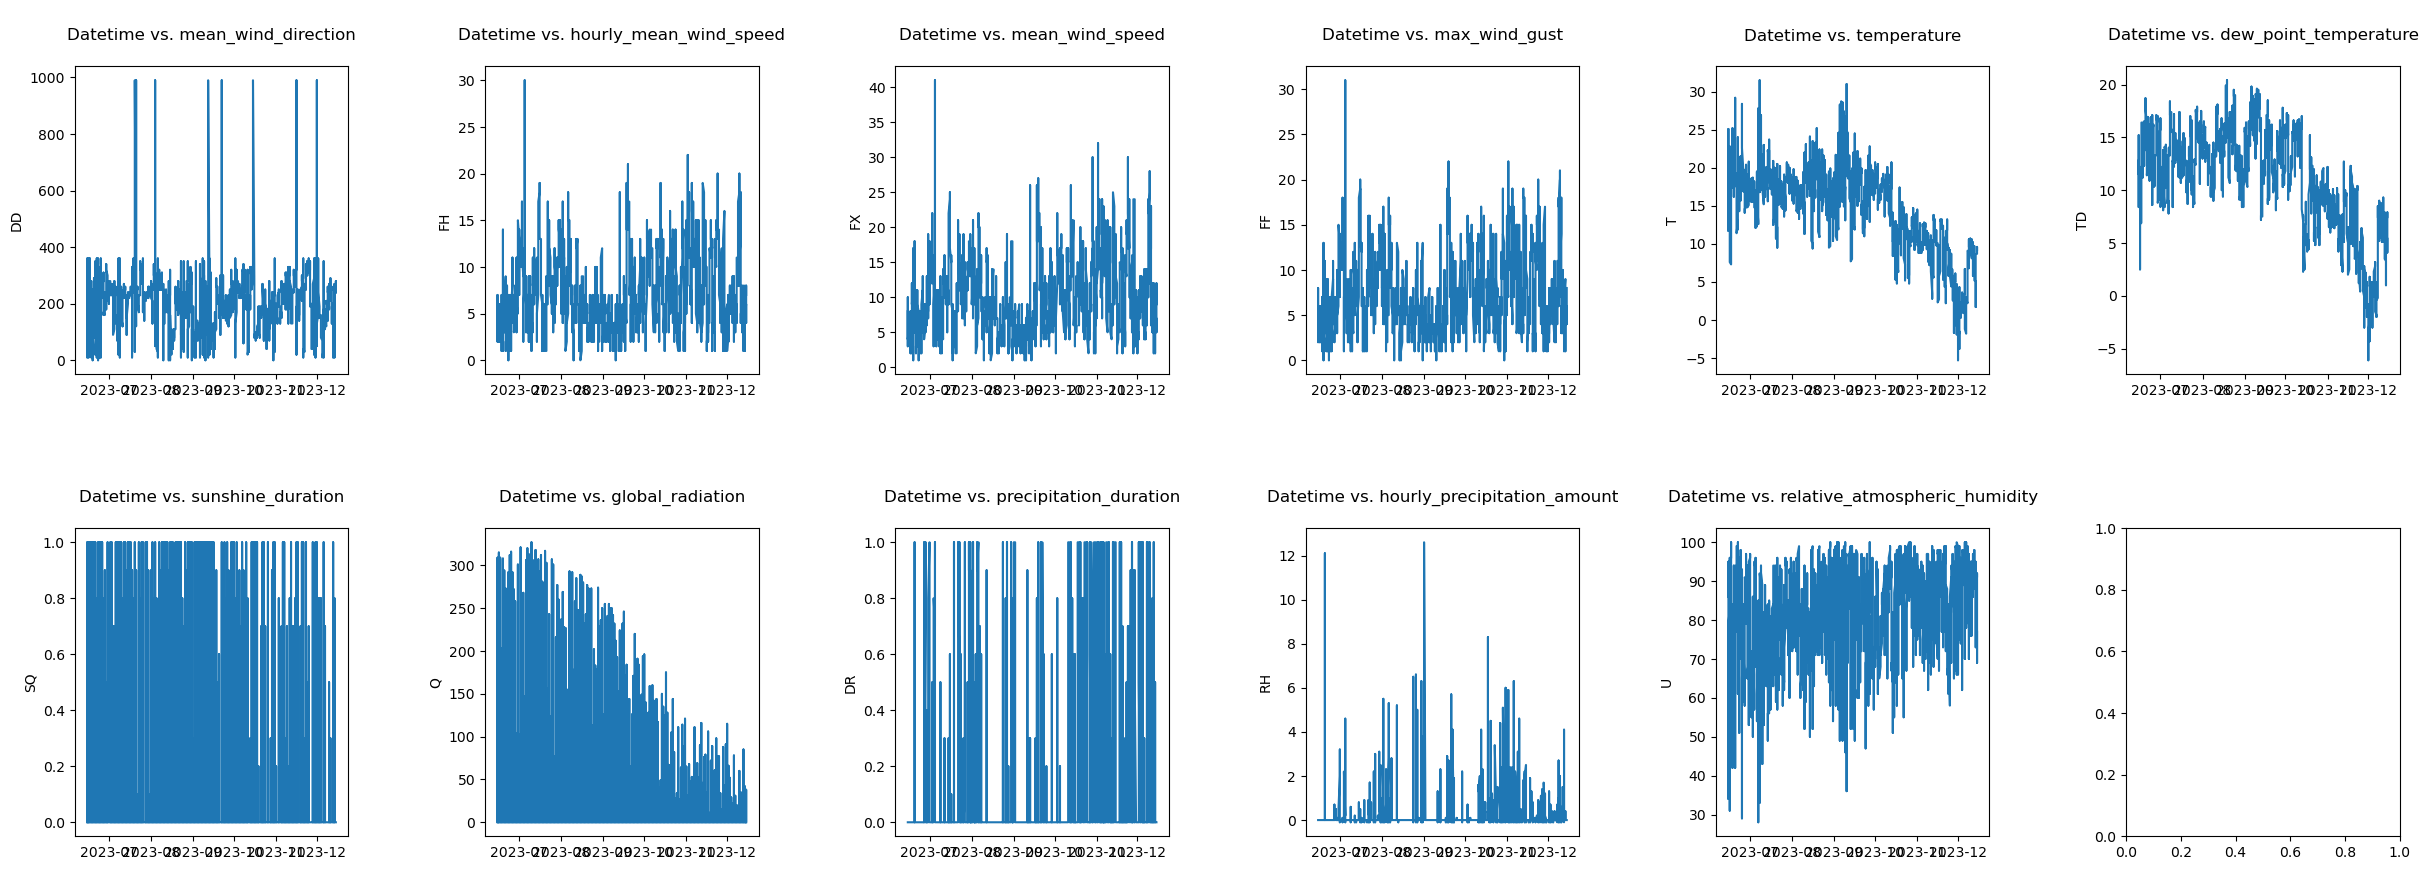

In [488]:
# Make subplots
fig, axs = plt.subplots(2,6, figsize = (30,10))
axs = axs.ravel()

#Print weather data
for i, ex in enumerate(weather_features):
    axs[i].set_title(f"\nDatetime vs. {name_dict[ex]}\n")
    axs[i].set_ylabel(f"{ex}")
    axs[i].plot(weather_station_df['date'], weather_station_df[ex])
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust the width and height space
plt.show()

### Analysis 2: Sensor Data

- Feature engineering: Date and time columns such that the table can easily be merged with sensor data and linked to time stamps of the recorded camera footage. + Adding location of tata steel to feature engineer distance and direction to the sensors
- Filtering on relevant locations surrounding the site
- Printing general statistics given the relevant sensor stations
- Removal of outliers (above 100ug)
- Plotting the PM2.5 values to get an overview of the distribution and its skewness

In [489]:
# Convert 'datetime' column to datetime type
sensor_df['datetime'] = pd.to_datetime(sensor_df['date'])

# Split 'datetime' column into 'date' and 'time' columns
sensor_df['date'] = sensor_df['datetime'].dt.date
sensor_df['time'] = sensor_df['datetime'].dt.time

#Print dataframe
sensor_df

,station,date,pm10_kal,pm25_kal,rh,temp,wd,ws,pres,pm10,pm25,lat,lon,datetime,time
0,HLL_hl_device_061,2023-06-15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.00,0.00,52.445,4.636,2023-06-15 01:00:00,01:00:00
1,HLL_hl_device_061,2023-06-15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.00,0.00,52.445,4.636,2023-06-15 02:00:00,02:00:00
2,HLL_hl_device_061,2023-06-15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.00,0.00,52.445,4.636,2023-06-15 03:00:00,03:00:00
3,HLL_hl_device_061,2023-06-15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.00,0.00,52.445,4.636,2023-06-15 04:00:00,04:00:00
4,HLL_hl_device_061,2023-06-15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.00,0.00,52.445,4.636,2023-06-15 05:00:00,05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126740,LTD_59609,2023-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.56,0.83,52.430,4.668,2023-11-02 18:00:00,18:00:00
126741,LTD_59609,2023-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.69,0.83,52.430,4.668,2023-11-02 19:00:00,19:00:00
126742,LTD_59609,2023-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.26,7.31,52.430,4.668,2023-12-01 09:00:00,09:00:00
126743,LTD_59609,2023-12-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.24,5.20,52.430,4.668,2023-12-06 13:00:00,13:00:00


##### Sensor Data: Add location of Tata Steel

In [490]:
sensor_df['tata_lat'] = 52.480234
sensor_df['tata_lon'] = 4.607623
sensor_df

,station,date,pm10_kal,pm25_kal,rh,temp,wd,ws,pres,pm10,pm25,lat,lon,datetime,time,tata_lat,tata_lon
0,HLL_hl_device_061,2023-06-15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.00,0.00,52.445,4.636,2023-06-15 01:00:00,01:00:00,52.480234,4.607623
1,HLL_hl_device_061,2023-06-15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.00,0.00,52.445,4.636,2023-06-15 02:00:00,02:00:00,52.480234,4.607623
2,HLL_hl_device_061,2023-06-15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.00,0.00,52.445,4.636,2023-06-15 03:00:00,03:00:00,52.480234,4.607623
3,HLL_hl_device_061,2023-06-15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.00,0.00,52.445,4.636,2023-06-15 04:00:00,04:00:00,52.480234,4.607623
4,HLL_hl_device_061,2023-06-15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.00,0.00,52.445,4.636,2023-06-15 05:00:00,05:00:00,52.480234,4.607623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126740,LTD_59609,2023-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.56,0.83,52.430,4.668,2023-11-02 18:00:00,18:00:00,52.480234,4.607623
126741,LTD_59609,2023-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.69,0.83,52.430,4.668,2023-11-02 19:00:00,19:00:00,52.480234,4.607623
126742,LTD_59609,2023-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.26,7.31,52.430,4.668,2023-12-01 09:00:00,09:00:00,52.480234,4.607623
126743,LTD_59609,2023-12-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.24,5.20,52.430,4.668,2023-12-06 13:00:00,13:00:00,52.480234,4.607623


##### Sensor Data: Filter on Stations

In [491]:
# Stations I'd like to keep
stations = ['HLL_hl_device_433']
other_stations = ['HLL_hl_device_237', 'HLL_hl_device_288', 'LTD_52030', 'HLL_hl_device_317', 'HLL_hl_device_452', 'HLL_hl_device_024']

#Filtering stations
filtered_df = sensor_df[sensor_df['station'].isin(other_stations)]

In [492]:
filtered_df['datetime'].unique()

<DatetimeArray>
['2023-06-15 01:00:00', '2023-06-15 02:00:00', '2023-06-15 03:00:00',
 '2023-06-15 04:00:00', '2023-06-15 05:00:00', '2023-06-15 06:00:00',
 '2023-06-15 07:00:00', '2023-06-15 08:00:00', '2023-06-15 09:00:00',
 '2023-06-15 10:00:00',
 ...
 '2024-02-14 16:00:00', '2024-02-14 17:00:00', '2024-02-14 18:00:00',
 '2024-02-14 19:00:00', '2024-02-14 20:00:00', '2024-02-14 21:00:00',
 '2024-02-14 22:00:00', '2024-02-14 23:00:00', '2024-01-19 02:00:00',
 '2024-01-30 07:00:00']
Length: 5787, dtype: datetime64[ns]

#### Sensor Data: Filter outliers

In [493]:
print("Df length with outliers:", len(filtered_df))
filtered_df = filtered_df[filtered_df['pm25'] <=100]
print("Df length without outliers:", len(filtered_df))

Df length with outliers: 23106
Df length without outliers: 22927


##### Sensor Data: Statistics

In [494]:
# Filtered statistics
filtered_total = len(filtered_df)
filtered_above20 = len(filtered_df[filtered_df['pm25'] >=20])
filtered_below20 = len(filtered_df[filtered_df['pm25'] <20])
filtered_average = round(filtered_df['pm25'].mean(),2)
filtered_perc_above20 = round(filtered_above20/filtered_total*100,2)
filtered_perc_below20 = round(filtered_below20/filtered_total*100,2)
filtered_min_value = filtered_df['pm25'].min()
filtered_max_value = filtered_df['pm25'].max()

print("---------------------------------------------------")
print("FILTERED STATS (STATIONS)")
print("Filtered df:", len(filtered_df))
print("Missing values:", filtered_df['pm25'].isnull().sum())
print("Minimum date:", filtered_df['date'].min())
print("Maximum date:", filtered_df['date'].max())
print("Minimum PM2.5 value:", filtered_df['pm25'].min())
print("Maximum PM2.5 value:", filtered_df['pm25'].max())

print("Instances above 20ug:", filtered_above20)
print("Instances below 20ug:", filtered_below20)
print("Average Pm 2.5:", filtered_average)
print("Percentage above 20:", filtered_perc_above20, "%")
print("Percentage below 20:", filtered_perc_below20, "%")


# Grouped statistics = group across station and date time
print("---------------------------------------------------")
print("GROUPED STATS")

grouped_df = filtered_df.groupby(['station', 'datetime'])['pm25_kal'].mean().reset_index(name='average_pm_25kal')
grouped_df['date'] = sensor_df['datetime'].dt.date
grouped_df['time'] = sensor_df['datetime'].dt.time
grouped_df['average_pm_25kal'] = grouped_df['average_pm_25kal'].clip(0,150)

#Some statistics
total = len(grouped_df)
above20 = len(grouped_df[grouped_df['average_pm_25kal'] >=20])
below20 = len(grouped_df[grouped_df['average_pm_25kal'] <20])
average = round(grouped_df['average_pm_25kal'].mean(),2)
perc_above20 = round(above20/total*100,2)
perc_below20 = round(below20/total*100,2)
min_value = grouped_df['average_pm_25kal'].min()
max_value = grouped_df['average_pm_25kal'].max()

print("Grouped df:", total)
print("Missing values:", grouped_df['average_pm_25kal'].isnull().sum())
print("Minimum date:", grouped_df['date'].min())
print("Maximum date:", grouped_df['date'].max())
print("Minimum PM2.5 value:", grouped_df['average_pm_25kal'].min())
print("Maximum PM2.5 value:", grouped_df['average_pm_25kal'].max())
print("Instances above 20ug:", above20)
print("Instances below 20ug:", below20)
print("Average Pm 2.5:", average)
print("Percentage above 20:", perc_above20, "%")
print("Percentage below 20:", perc_below20, "%")


---------------------------------------------------
FILTERED STATS (STATIONS)
Filtered df: 22927
Missing values: 0
Minimum date: 2023-06-15
Maximum date: 2024-02-14
Minimum PM2.5 value: 0.55
Maximum PM2.5 value: 89.99
Instances above 20ug: 2229
Instances below 20ug: 20698
Average Pm 2.5: 8.97
Percentage above 20: 9.72 %
Percentage below 20: 90.28 %
---------------------------------------------------
GROUPED STATS
Grouped df: 22470
Missing values: 235
Minimum date: 2023-06-15
Maximum date: 2024-02-14
Minimum PM2.5 value: 0.339708
Maximum PM2.5 value: 89.99
Instances above 20ug: 1992
Instances below 20ug: 20243
Average Pm 2.5: 9.22
Percentage above 20: 8.87 %
Percentage below 20: 90.09 %


##### Sensor Data: Plot PM2.5

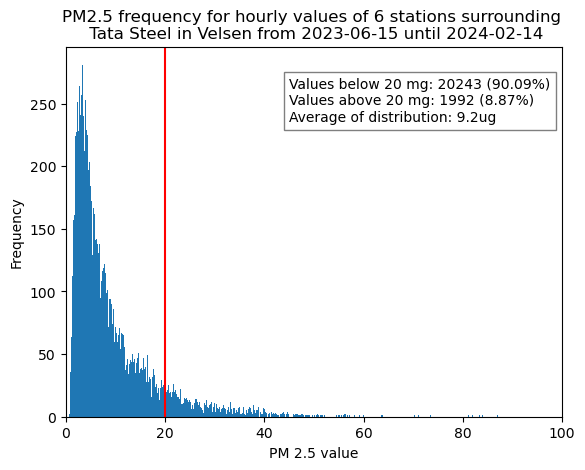

In [495]:
min_date = filtered_df['date'].min()
max_date = filtered_df['date'].max()
plt.hist(filtered_df['pm25'], bins = 1000)
plt.ylabel("Frequency")
plt.xlabel('PM 2.5 value')
plt.title(f'PM2.5 frequency for hourly values of {len(other_stations)} stations surrounding \n Tata Steel in Velsen from {min_date} until {max_date}')
plt.xlim(0,100)
# plt.ylim(0,150)

# Draw a vertical line at value 20
plt.axvline(x=20, color='r', linestyle='-')

# Get plot dimensions
x_max = plt.xlim()[1]
y_max = plt.ylim()[1]


# Add annotation box
plt.text(x_max - 0.55 * x_max, y_max - 0.2*y_max, f'Values below 20 mg: {below20} ({perc_below20}%)\nValues above 20 mg: {above20} ({perc_above20}%)\nAverage of distribution: {average:.1f}ug'
         , bbox=dict(facecolor='white', alpha=0.5))

plt.show()

### Analysis Sensor and Weather Data Correlations

In [496]:
# Join sensor and weather data based on date
sensor_weather_df = pd.merge(grouped_df, weather_station_df, on=["date", "time"], suffixes=('_sensor', '_weather'))
sensor_weather_df.head(5)

,station,datetime_sensor,average_pm_25kal,date,time,# STN_225,YYYYMMDD,HH,DD,FH,...,FF,# STN_257,T,TD,SQ,Q,DR,RH,U,datetime_weather
0,HLL_hl_device_237,2023-06-15 01:00:00,6.34,2023-06-15,01:00:00,225,20230615,1,70,6.0,...,6.0,257,15.0,12.8,0.0,0,0.0,0.0,86,2023-06-15
1,HLL_hl_device_237,2023-12-12 05:00:00,3.47,2023-06-15,01:00:00,225,20230615,1,70,6.0,...,6.0,257,15.0,12.8,0.0,0,0.0,0.0,86,2023-06-15
2,HLL_hl_device_288,2023-11-15 14:00:00,5.44,2023-06-15,01:00:00,225,20230615,1,70,6.0,...,6.0,257,15.0,12.8,0.0,0,0.0,0.0,86,2023-06-15
3,HLL_hl_device_452,2023-11-12 17:00:00,19.09,2023-06-15,01:00:00,225,20230615,1,70,6.0,...,6.0,257,15.0,12.8,0.0,0,0.0,0.0,86,2023-06-15
4,LTD_52030,2023-11-25 07:00:00,6.30,2023-06-15,01:00:00,225,20230615,1,70,6.0,...,6.0,257,15.0,12.8,0.0,0,0.0,0.0,86,2023-06-15


### Sensor Data and Wind Direction

In [497]:
# Create dataset
wind_direction = pd.merge(filtered_df[['lat', 'lon', 'date', 'time', 'pm25', 'tata_lat', 'tata_lon', 'station']], weather_station_df[['FH', 'DD', 'FF', 'FX', 'date', 'time']], on = ['date', 'time'], how='inner')

##### Add distance and direction feature

In [498]:
# Create Distance and Direction features from Tata Steel to the sensors
wind_direction['distance'] = 0
wind_direction['direction'] = 0

# Coordinates of the point
point_x = 52.480234
point_y = 4.607623

# Function to calculate the distance between two points
def calculate_distance(sensor_x, sensor_y, point_x, point_y):
    return math.sqrt((sensor_x - point_x)**2 + (sensor_y - point_y)**2)

# Function to calculate the angle between two points
def calculate_angle(sensor_x, sensor_y, point_x, point_y):
    if math.degrees(math.atan2(sensor_y - point_y, sensor_x - point_x)) <0:
        return 360 + math.degrees(math.atan2(sensor_y - point_y, sensor_x - point_x))
    else:
        return math.degrees(math.atan2(sensor_y - point_y, sensor_x - point_x))

for index, row in wind_direction.iterrows():
    lat1, lon1 = row[['lat', 'lon']].astype(float) # lat and lon of the sensors
    lat2, lon2 = row[['tata_lat', 'tata_lon']].astype(float)  # lat and lon of Tata Steel 

    # Calculate distance and direction
    distance = calculate_distance(lat1, lon1, lat2, lon2)
    direction = calculate_angle(lat1, lon1, lat2, lon2)
    wind_direction.loc[index, 'distance'] = distance
    wind_direction.loc[index,'direction'] = direction
wind_direction


,lat,lon,date,time,pm25,tata_lat,tata_lon,station,FH,DD,FF,FX,distance,direction
0,52.463,4.595,2023-06-15,01:00:00,6.34,52.480234,4.607623,HLL_hl_device_237,6.0,70,6.0,8.0,0.021362,216.220818
1,52.463,4.596,2023-06-15,01:00:00,7.21,52.480234,4.607623,HLL_hl_device_288,6.0,70,6.0,8.0,0.020787,213.996619
2,52.475,4.641,2023-06-15,01:00:00,3.71,52.480234,4.607623,HLL_hl_device_452,6.0,70,6.0,8.0,0.033785,98.912233
3,52.463,4.595,2023-06-15,02:00:00,8.17,52.480234,4.607623,HLL_hl_device_237,5.0,80,5.0,7.0,0.021362,216.220818
4,52.463,4.596,2023-06-15,02:00:00,9.32,52.480234,4.607623,HLL_hl_device_288,5.0,80,5.0,7.0,0.020787,213.996619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,52.475,4.641,2023-09-09,07:00:00,43.81,52.480234,4.607623,HLL_hl_device_452,2.0,220,2.0,3.0,0.033785,98.912233
16574,52.475,4.641,2023-09-09,08:00:00,47.74,52.480234,4.607623,HLL_hl_device_452,2.0,220,2.0,3.0,0.033785,98.912233
16575,52.464,4.628,2023-09-09,08:00:00,87.03,52.480234,4.607623,LTD_52030,2.0,220,2.0,3.0,0.026053,128.543720
16576,52.475,4.641,2023-12-01,05:00:00,18.66,52.480234,4.607623,HLL_hl_device_452,6.0,70,6.0,10.0,0.033785,98.912233


##### Add direction difference and boolean 'smaller_90' variable to see if it is in the same quadrant

In [499]:
wind_direction['direction_difference'] = abs(wind_direction['DD'].astype(float)- wind_direction['direction'])
wind_direction['smaller_90'] = wind_direction['direction_difference'] < 90
wind_direction

,lat,lon,date,time,pm25,tata_lat,tata_lon,station,FH,DD,FF,FX,distance,direction,direction_difference,smaller_90
0,52.463,4.595,2023-06-15,01:00:00,6.34,52.480234,4.607623,HLL_hl_device_237,6.0,70,6.0,8.0,0.021362,216.220818,146.220818,False
1,52.463,4.596,2023-06-15,01:00:00,7.21,52.480234,4.607623,HLL_hl_device_288,6.0,70,6.0,8.0,0.020787,213.996619,143.996619,False
2,52.475,4.641,2023-06-15,01:00:00,3.71,52.480234,4.607623,HLL_hl_device_452,6.0,70,6.0,8.0,0.033785,98.912233,28.912233,True
3,52.463,4.595,2023-06-15,02:00:00,8.17,52.480234,4.607623,HLL_hl_device_237,5.0,80,5.0,7.0,0.021362,216.220818,136.220818,False
4,52.463,4.596,2023-06-15,02:00:00,9.32,52.480234,4.607623,HLL_hl_device_288,5.0,80,5.0,7.0,0.020787,213.996619,133.996619,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,52.475,4.641,2023-09-09,07:00:00,43.81,52.480234,4.607623,HLL_hl_device_452,2.0,220,2.0,3.0,0.033785,98.912233,121.087767,False
16574,52.475,4.641,2023-09-09,08:00:00,47.74,52.480234,4.607623,HLL_hl_device_452,2.0,220,2.0,3.0,0.033785,98.912233,121.087767,False
16575,52.464,4.628,2023-09-09,08:00:00,87.03,52.480234,4.607623,LTD_52030,2.0,220,2.0,3.0,0.026053,128.543720,91.456280,False
16576,52.475,4.641,2023-12-01,05:00:00,18.66,52.480234,4.607623,HLL_hl_device_452,6.0,70,6.0,10.0,0.033785,98.912233,28.912233,True


In [500]:
wind_direction[(wind_direction['date'] == pd.to_datetime('2023-06-15 00:00:00').date())]

,lat,lon,date,time,pm25,tata_lat,tata_lon,station,FH,DD,FF,FX,distance,direction,direction_difference,smaller_90
0,52.463,4.595,2023-06-15,01:00:00,6.34,52.480234,4.607623,HLL_hl_device_237,6.0,70,6.0,8.0,0.021362,216.220818,146.220818,False
1,52.463,4.596,2023-06-15,01:00:00,7.21,52.480234,4.607623,HLL_hl_device_288,6.0,70,6.0,8.0,0.020787,213.996619,143.996619,False
2,52.475,4.641,2023-06-15,01:00:00,3.71,52.480234,4.607623,HLL_hl_device_452,6.0,70,6.0,8.0,0.033785,98.912233,28.912233,True
3,52.463,4.595,2023-06-15,02:00:00,8.17,52.480234,4.607623,HLL_hl_device_237,5.0,80,5.0,7.0,0.021362,216.220818,136.220818,False
4,52.463,4.596,2023-06-15,02:00:00,9.32,52.480234,4.607623,HLL_hl_device_288,5.0,80,5.0,7.0,0.020787,213.996619,133.996619,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,52.463,4.595,2023-06-15,22:00:00,15.99,52.480234,4.607623,HLL_hl_device_237,3.0,30,3.0,4.0,0.021362,216.220818,186.220818,False
64,52.463,4.596,2023-06-15,22:00:00,12.89,52.480234,4.607623,HLL_hl_device_288,3.0,30,3.0,4.0,0.020787,213.996619,183.996619,False
65,52.475,4.641,2023-06-15,22:00:00,4.76,52.480234,4.607623,HLL_hl_device_452,3.0,30,3.0,4.0,0.033785,98.912233,68.912233,True
16546,52.463,4.596,2023-06-15,23:00:00,13.72,52.480234,4.607623,HLL_hl_device_288,2.0,80,2.0,3.0,0.020787,213.996619,133.996619,False


In [501]:
data2 = wind_direction.copy()
data2 = data2.dropna()
result = data2.groupby(['date', 'time', 'station']).apply(lambda x: x.loc[x['pm25'].idxmax()])[['pm25', 'direction', 'DD', 'direction_difference']]
result[result['pm25']>=20]
# result.tail(20)

pm25   direction   DD  \
date       time     station                                     
2023-06-17 03:00:00 HLL_hl_device_237  26.73  216.220818  350   
           04:00:00 HLL_hl_device_237  24.12  216.220818  310   
                    HLL_hl_device_288  22.27  213.996619  310   
           05:00:00 HLL_hl_device_237  33.17  216.220818  310   
                    HLL_hl_device_288  28.89  213.996619  310   
...                                      ...         ...  ...   
2023-12-13 21:00:00 HLL_hl_device_288  38.18  213.996619   40   
           22:00:00 HLL_hl_device_237  44.51  216.220818   40   
                    HLL_hl_device_288  39.17  213.996619   40   
           23:00:00 HLL_hl_device_237  40.33  216.220818   30   
                    HLL_hl_device_288  36.13  213.996619   30   

                                       direction_difference  
date       time     station                                  
2023-06-17 03:00:00 HLL_hl_device_237            133.779182  
           04:00:00 HLL_hl_device_237             93.779182  
                    HLL_hl_device_288             96.003381  
           05:00:00 HLL_hl_device_237             93.779182  
                    HLL_hl_device_288             96.003381  
...                                                     ...  
2023-12-13 21:00:00 HLL_hl_device_288            173.996619  
           22:00:00 HLL_hl_device_237            176.220818  
                    HLL_hl_device_288            173.996619  
           23:00:00 HLL_hl_device_237            186.220818  
                    HLL_hl_device_288            183.996619  

[1651 rows x 4 columns]

#### Simple regression ML model

In [502]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# Split data into features (X) and target variable (y)
wind_direction.dropna(inplace=True)
print("Number of instances", len(wind_direction))
X = wind_direction[['lat', 'lon', 'FH', 'DD', 'tata_lat', 'tata_lon', 'distance', 'direction', 'smaller_90']]
y = wind_direction['pm25']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create and train the model
# model = LinearRegression()
model = GradientBoostingRegressor()
# model = RandomForestRegressor()

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation

model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Number of instances 16578
Mean Squared Error: 69.07829494274141
R-squared Score: 0.17324551728598647
Cross-Validation Scores: [0.17670625 0.16737419 0.19291598 0.16349241 0.15642963]
Mean Cross-Validation Score: 0.17138369153393437
